<a href="https://colab.research.google.com/github/wandb/edu/blob/main/lightning/projects/chess_piece_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />

# Chess Piece Detection

## Installations and Imports

In [ ]:
%%capture
!pip install pytorch_lightning==1.3.8 wandb wonderwords
!git clone https://github.com/wandb/lit_utils
!cd "/content/lit_utils" && git pull

import wandb

import lit_utils as lu

!git clone https://github.com/ultralytics/yolov5 /content/yolov5  # clone repo
!pip install -qr /content/yolov5/requirements.txt  # install dependencies

%cd /content/yolov5

In [ ]:
wandb.login()

## Download Dataset

The dataset consists of object-level labeled images
of a single chessboard and chess set
in uniform conditions.

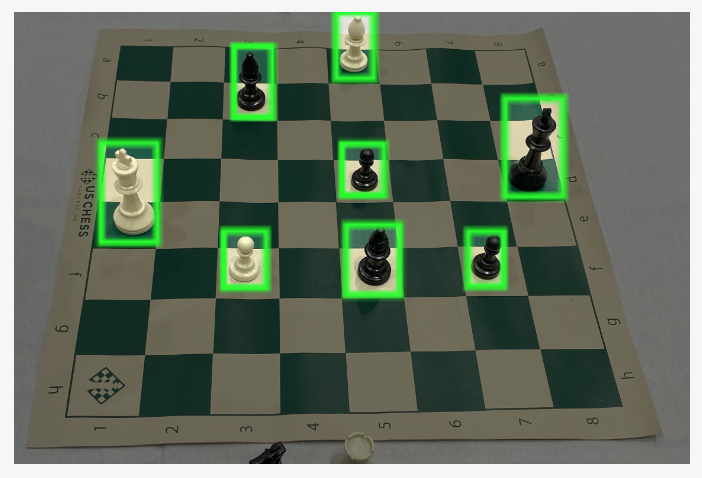

Originally made by and hosted at [Roboflow](https://public.roboflow.com/object-detection/chess-full),
here downloaded from Weights & Biases.

In [ ]:
with wandb.init(entity="wandb", project="yolo-chess", job_type="download-dataset") as run:
    dataset_at = run.use_artifact("wandb/yolo-chess/chess-dataset:latest")
    dataset_at.download("/content/chess")

## Set Hyperparameters

Written to a file by the cell below and then read during training.

For folks who aren't experts in object detection,
the data augmentation hyperparameters are easier to reason about.

By default, the data augmentation is turned up to 11.
You might find that lower levels of augmentation give better results,
especially for shorter training times.

In [ ]:
%%writefile data/hyp.chess.yaml

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
##
# Data Augmentation Hyperparameters
##
hsv_h: 0.9  # image HSV-Hue augmentation (fraction)
hsv_s: 0.9  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.9  # image HSV-Value augmentation (fraction)
degrees: 180.0  # image rotation (+/- deg)
translate: 0.7  # image translation (+/- fraction)
scale: 3.0  # image scale (+/- gain)
shear: 45.0  # image shear (+/- deg)
perspective: 0.001  # image perspective (+/- fraction), range 0-0.001
flipud: 0.5  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.0  # image mosaic (probability)
mixup: 1.0  # image mixup (probability)
copy_paste: 0.0  # do not use image segmentation aug style

## Fine-tune a Pre-Trained Model

Edit the variables at the top of the cell to change training time (`batch_size`, `epochs`)
and which [size of the YOLOv5 model](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data#4-select-a-model)
you are training
(from `s`mall to `x`tra-large).

> ⚠️ *Watch out*! If you increase the `batch_size` too much,
especially for the `l`arge or `x`tra-large models,
you can run out GPU memory.
You'll see an error message about a `RuntimeError: CUDA out of memory.`
Just reduce `batch_size` until you can launch without errors.
`batch_size = 16` should always work.


For more details on the arguments and their purpose,
run `!python train.py --help` or
check out [the GitHub repo](https://github.com/ultralytics/yolov5).

In [ ]:
batch_size = 16 
epochs = 10
weights = "yolov5s.pt" # v5s.pt v5m.pt v5l.pt v5x.pt

!python train.py \
  --project yolo-chess \
  --entity wandb \
  --upload_dataset \
  --name {lu.utils.make_random_name()} \
  --hyp data/hyp.chess.yaml \
  --data /content/chess/data.yaml \
  --weights {weights} \
  --epochs {epochs} \
  --batch-size {batch_size} \
  --bbox_interval {min(2, epochs)} \
  --save-period {min(5, epochs)} \

## Train from Scratch

In [ ]:
batch_size = 16
epochs = 100
cfg = "yolov5s.yaml" # v5s.yaml v5m.yaml v5l.yaml v5x.yaml

!python train.py \
  --project yolo-chess \
  --entity wandb \
  --upload_dataset \
  --name {lu.utils.make_random_name()} \
  --hyp data/hyp.chess.yaml \
  --data /content/chess/data.yaml \
  --weights "" \
  --cfg {cfg} \
  --epochs {epochs} \
  --batch-size {batch_size} \
  --bbox_interval {min(5, epochs)} \
  --save-period {min(10, epochs)} \